<a href="https://colab.research.google.com/github/harshitt018/Advance-Data-Science/blob/main/CNN_using_Oxford_IIIT_Pet_Dataset_Harshit_Jaiswal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dataset info**

**🔹 Oxford-IIIT Pet Dataset**

- **Size**: ~7,400 images

- **Classes**: 37 different pet breeds (cats & dogs)

  - e.g., Persian cat, Siamese cat, Pug, German Shepherd, etc.

- **Why it’s useful:**

  - **Multi-class classification** → harder than binary (requires CNN to differentiate between many subtle classes).

  - **Comes with segmentation masks** → allows you to try advanced tasks like object segmentation, not just classification.

  - **High variety**: different poses, lighting, occlusions.

#**Step 1 — Import all the required libraries & setup**
- **MobileNetV2** → a pre-trained CNN model (lightweight, fast, trained on ImageNet).
You’ll probably fine-tune it on your dataset instead of training a CNN from scratch.

- **preprocess_input** → a function to preprocess images exactly the way MobileNetV2 expects (e.g., scaling pixels to `[-1,1]`).

- **layers** → contains building blocks for neural nets (Dense, Conv2D, Dropout, Flatten, etc.).

- **Sequential** → a way to stack layers in a linear model (input → hidden layers → output).

In [28]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras import layers, Sequential

tf.random.set_seed(42)
print("TensorFlow:", tf.__version__)

TensorFlow: 2.19.0


# **Step 2 — Load dataset**
🔹 tfds.load() → loads a dataset from TensorFlow Datasets (TFDS).

- `"oxford_iiit_pet"` → the dataset name (comes built into TFDS).

- `split`=["train", "test"] → loads both train and test sets separately.

- `as_supervised`=True → ensures each example comes as a tuple (image, label) instead of a dictionary.
👉 Example: (image, label) instead of {"image": ..., "label": ...}

- `with_info`=True → also returns metadata about the dataset (like class names, total size, etc.).

In [29]:
(train_ds, test_ds), ds_info = tfds.load(
    "oxford_iiit_pet",
    split=["train", "test"],
    as_supervised=True,   # (image, label)
    with_info=True
)

NUM_CLASSES = ds_info.features["label"].num_classes
CLASS_NAMES = ds_info.features["label"].names
print("Classes:", NUM_CLASSES)
print("Example classes:", CLASS_NAMES[:5])

Classes: 37
Example classes: ['Abyssinian', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle']


# **Step 3 — Preprocess & build pipelines**

`MobileNetV2 expects inputs in [-1, 1] → use preprocess_input.`

- `IMG_SIZE` = 224 → all images will be resized to 224×224 pixels (the input size expected by MobileNetV2 or similar CNNs).

- `BATCH_SIZE` = 32 → instead of processing images one by one, the dataset will be split into mini-batches of 32 images for faster training.

- `tf.image.resize(image, [IMG_SIZE, IMG_SIZE])` → resizes original dataset images (which have varying sizes) into 224x224.

- `tf.cast(image, tf.float32)` → ensures pixel values are floats (needed for training, since original is uint8).

- `preprocess_input(image)` → this is from MobileNetV2 preprocessing:

  - Takes pixel values (0–255)

  - Converts them to the range [-1, 1]

  - Helps the model train better, because it matches how MobileNet was originally trained.

- `.map(preprocess, ...)` → applies your preprocessing function to each (image, label) pair.

- `.shuffle(1000)` → randomizes training samples (prevents model from memorizing order).

- `.batch(BATCH_SIZE)` → groups 32 samples per batch for training.

- `.prefetch(tf.data.AUTOTUNE)` → overlaps data loading with model training for faster performance.

In [30]:
IMG_SIZE = 224
BATCH_SIZE = 32

def preprocess(image, label):
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.float32)           # 0..255
    image = preprocess_input(image)              # -> [-1, 1]
    return image, label

train_ds = (train_ds
            .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
            .shuffle(1000)
            .batch(BATCH_SIZE)
            .prefetch(tf.data.AUTOTUNE))

test_ds = (test_ds
           .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
           .batch(BATCH_SIZE)
           .prefetch(tf.data.AUTOTUNE))

# **Step 4 — Data augmentation**

In [31]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# **Step 5 — Build model (MobileNetV2 + head)**
- `MobileNetV2` → a pre-trained CNN (Convolutional Neural Network) from Google, trained on ImageNet (1.4M images, 1000 classes).

- `input_shape`=(224, 224, 3) → your input images are resized to 224×224 with 3 color channels (RGB).

- `include_top`=False → removes the original classifier (1000 classes of ImageNet). We only keep the feature extractor part.

- `weights`="imagenet" → we use pre-trained weights so the model already knows generic features like edges, fur textures, shapes, etc.

1. `data_augmentation`

  - Applies flips/rotations/zooms dynamically → makes training more robust.

2. `base_model` (MobileNetV2)

    - Extracts powerful pet features (ears, fur, face shape, etc).

3. `GlobalAveragePooling2D()`

    - Converts the last convolutional feature maps into a single 1D feature vector per image.

    - Instead of flattening everything, it takes the average of each feature map → reduces parameters.

4. `Dropout(0.30)`

    - Randomly turns off 30% neurons during training.

    - Prevents overfitting (model doesn’t rely too much on certain features).

5. `Dense(NUM_CLASSES, activation="softmax")`

    - Final classification layer.

    - Output size = number of pet breeds (NUM_CLASSES = 37 for Oxford-IIIT).

    - Softmax gives probabilities for each breed.

In [33]:
base_model = MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False  # freeze backbone initially

model = Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.30),
    layers.Dense(NUM_CLASSES, activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

# **Step 6 — Train (Stage 1: backbone frozen)**
**1. EarlyStopping**
`es = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)`

- **What it does**: Stops training early if validation accuracy/loss doesn’t improve.

- `patience`=3 → waits for 3 epochs of no improvement before stopping.

- `restore_best_weights`=True → after stopping, it reloads the best model weights (not the last ones, which might be worse).

**👉 Prevents overfitting and wasted training time.**


---

**2. ModelCheckpoint**
`ckpt = tf.keras.callbacks.ModelCheckpoint("pet_best_stage1.h5", save_best_only=True)`
- **What it does**: Saves your model during training.

- `File name `→ "pet_best_stage1.h5"

- `save_best_only`=True → only the best-performing model on validation data will be saved (not every epoch).

**👉 Useful so you don’t lose the best weights if later epochs overfit.**


---

**3. ReduceLROnPlateau**

`rlr = tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, verbose=1)`
- **What it does**: Reduces the learning rate when validation accuracy/loss stops improving.

- `patience`=2 → waits 2 epochs before reducing LR.

- `factor`=0.5 → multiplies current LR by 0.5 (cuts it in half).

- `verbose`=1 → prints a message when LR is reduced.

**👉 Helps the optimizer fine-tune weights instead of getting stuck.**


In [34]:
es = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
ckpt = tf.keras.callbacks.ModelCheckpoint("pet_best_stage1.h5", save_best_only=True)
rlr = tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, verbose=1)

history1 = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    callbacks=[es, ckpt, rlr]
)

Epoch 1/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.3932 - loss: 2.3910

115/115 ━━━━━━━━━━━━━━━━━━━━ 33s 221ms/step - accuracy: 0.3950 - loss: 2.3837 - val_accuracy: 0.8476 - val_loss: 0.5650 - learning_rate: 0.0010
Epoch 2/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.8336 - loss: 0.5727

115/115 ━━━━━━━━━━━━━━━━━━━━ 34s 269ms/step - accuracy: 0.8336 - loss: 0.5725 - val_accuracy: 0.8703 - val_loss: 0.4399 - learning_rate: 0.0010
Epoch 3/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.8707 - loss: 0.4269

115/115 ━━━━━━━━━━━━━━━━━━━━ 35s 277ms/step - accuracy: 0.8707 - loss: 0.4269 - val_accuracy: 0.8814 - val_loss: 0.3926 - learning_rate: 0.0010
Epoch 4/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8962 - loss: 0.3439

115/115 ━━━━━━━━━━━━━━━━━━━━ 35s 283ms/step - accuracy: 0.8962 - loss: 0.3440 - val_accuracy: 0.8869 - val_loss: 0.3559 - learning_rate: 0.0010
Epoch 5/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9163 - loss: 0.2892

115/115 ━━━━━━━━━━━━━━━━━━━━ 34s 275ms/step - accuracy: 0.9163 - loss: 0.2892 - val_accuracy: 0.8959 - val_loss: 0.3390 - learning_rate: 0.0010
Epoch 6/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 33s 195ms/step - accuracy: 0.9196 - loss: 0.2646 - val_accuracy: 0.8833 - val_loss: 0.3535 - learning_rate: 0.0010
Epoch 7/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9342 - loss: 0.2286

115/115 ━━━━━━━━━━━━━━━━━━━━ 40s 184ms/step - accuracy: 0.9342 - loss: 0.2285 - val_accuracy: 0.8902 - val_loss: 0.3379 - learning_rate: 0.0010
Epoch 8/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 40s 186ms/step - accuracy: 0.9316 - loss: 0.2141 - val_accuracy: 0.8877 - val_loss: 0.3592 - learning_rate: 0.0010
Epoch 9/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9369 - loss: 0.2062
Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
115/115 ━━━━━━━━━━━━━━━━━━━━ 26s 201ms/step - accuracy: 0.9369 - loss: 0.2063 - val_accuracy: 0.8910 - val_loss: 0.3505 - learning_rate: 0.0010
Epoch 10/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 25s 197ms/step - accuracy: 0.9435 - loss: 0.1884 - val_accuracy: 0.8863 - val_loss: 0.3521 - learning_rate: 5.0000e-04


# **Step 7 — Fine-tune (Stage 2: unfreeze top of backbone)**
- At first you froze the entire MobileNetV2 (so only your custom dense layers trained).

- Now → you unfreeze only the last ~30 layers (closer to the output).

- Why?

    - Early layers learn generic features (edges, textures, shapes).

    - Later layers learn task-specific features (like pet faces).

- Freezing most layers prevents overfitting & keeps training efficient.

👉 You are telling the model:
“Keep the general features fixed, but adapt the deeper layers to pets.”

---

- **Why small LR (1e-5)?**

  - Because we don’t want to destroy pretrained weights with large updates.

  - Fine-tuning requires tiny adjustments.

- Loss is still sparse_categorical_crossentropy (since labels are integers, not one-hot).
-
Metric is accuracy.

In [35]:
# Unfreeze the top ~30 layers of the backbone
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # small LR for fine-tuning
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

ckpt2 = tf.keras.callbacks.ModelCheckpoint("pet_best_stage2.h5", save_best_only=True)

history2 = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5,
    callbacks=[es, ckpt2, rlr]
)

Epoch 1/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.8704 - loss: 0.4203

115/115 ━━━━━━━━━━━━━━━━━━━━ 39s 227ms/step - accuracy: 0.8704 - loss: 0.4202 - val_accuracy: 0.8923 - val_loss: 0.3237 - learning_rate: 1.0000e-05
Epoch 2/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.8827 - loss: 0.3613

115/115 ━━━━━━━━━━━━━━━━━━━━ 37s 212ms/step - accuracy: 0.8827 - loss: 0.3613 - val_accuracy: 0.8929 - val_loss: 0.3198 - learning_rate: 1.0000e-05
Epoch 3/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.8996 - loss: 0.3198

115/115 ━━━━━━━━━━━━━━━━━━━━ 27s 211ms/step - accuracy: 0.8996 - loss: 0.3197 - val_accuracy: 0.8932 - val_loss: 0.3173 - learning_rate: 1.0000e-05
Epoch 4/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 36s 285ms/step - accuracy: 0.9106 - loss: 0.2979 - val_accuracy: 0.8940 - val_loss: 0.3188 - learning_rate: 1.0000e-05
Epoch 5/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9139 - loss: 0.2887


Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
115/115 ━━━━━━━━━━━━━━━━━━━━ 36s 292ms/step - accuracy: 0.9138 - loss: 0.2887 - val_accuracy: 0.8953 - val_loss: 0.3173 - learning_rate: 1.0000e-05


# **Step 8 — Curves & evaluation**
- `plot_curves function` → plots training & validation curves for both Stage 1 and Stage 2:

  - `key`="accuracy" → plots accuracy over epochs.

  - `key`="loss" → plots loss over epochs.

  - Lets you visually compare improvements after fine-tuning.

- `model.evaluate(test_ds)` → runs the final model on the test dataset to get:

- `loss` → how well the model fits.

- `acc` → final test accuracy.

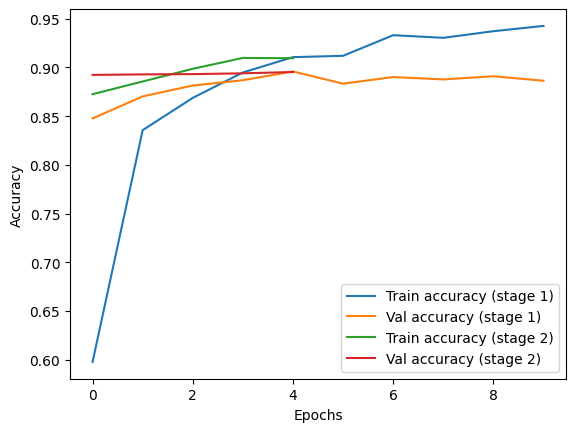

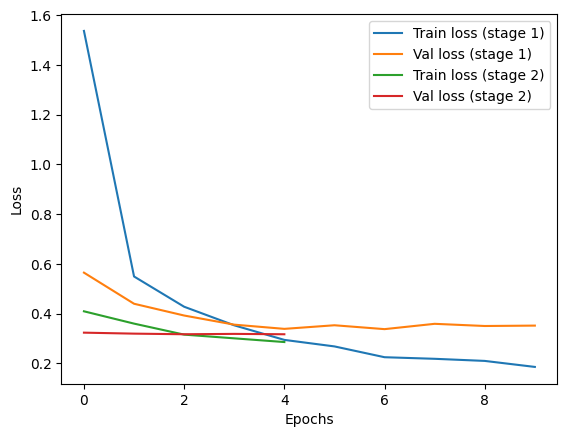

115/115 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - accuracy: 0.8986 - loss: 0.3142
✅ Final Test Accuracy: 89.53%


In [36]:
def plot_curves(hists, key="accuracy"):
    plt.figure()
    for i, h in enumerate(hists, 1):
        plt.plot(h.history[key], label=f"Train {key} (stage {i})")
        plt.plot(h.history[f"val_{key}"], label=f"Val {key} (stage {i})")
    plt.xlabel("Epochs")
    plt.ylabel(key.capitalize())
    plt.legend()
    plt.show()

plot_curves([history1, history2], key="accuracy")
plot_curves([history1, history2], key="loss")

loss, acc = model.evaluate(test_ds)
print(f"✅ Final Test Accuracy: {acc:.2%}")

# **Step 9 — Batch predictions (correct label mapping)**
- **Takes 1 batch from test_ds.**

- `model.predict(images)` → gets predicted probabilities.

- `np.argmax` → picks the class with highest probability.

- Plots 9 images in a 3×3 grid:

  - Shows each image.

  - Displays True label vs Predicted label.

  - Turns off axes for cleaner display.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


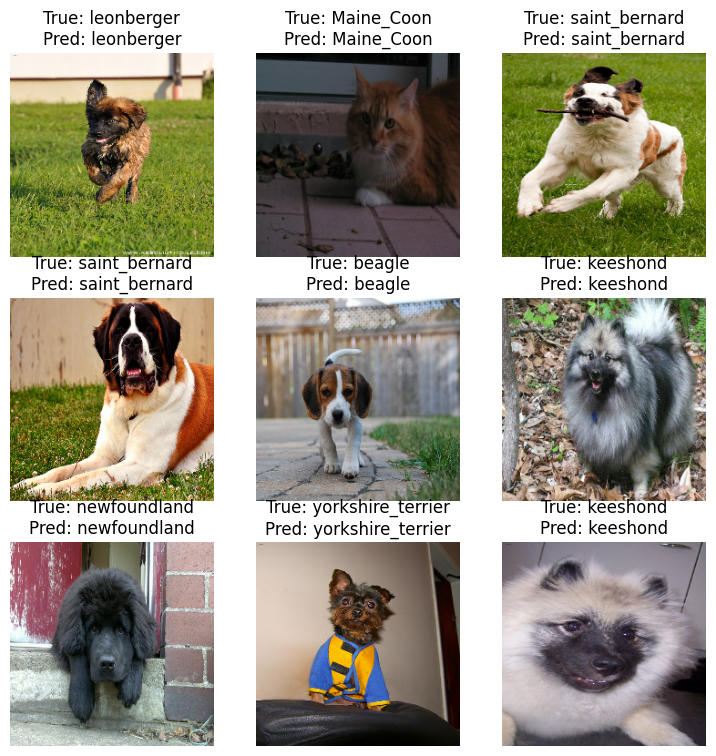

In [38]:
# Show 9 predictions from test set
for images, labels in test_ds.take(1):
    preds = model.predict(images)
    pred_labels = np.argmax(preds, axis=1)

    plt.figure(figsize=(9,9))
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow((images[i].numpy() + 1.0) / 2.0)  # de-normalize from [-1,1] to [0,1] for display
        true_idx = int(labels[i].numpy())
        pred_idx = int(pred_labels[i])
        plt.title(f"True: {CLASS_NAMES[true_idx]}\nPred: {CLASS_NAMES[pred_idx]}")
        plt.axis("off")
    plt.show()


# **Step 10 — Single image prediction (correct preprocessing!)**
- **Imports tools:**

  - `files.upload()` → lets you upload a file from your computer.

  - `load_img`, `img_to_array` → load an image and convert it to a NumPy array.

In [48]:
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded = files.upload()  # Opens a file picker in Colab → you choose a pet image (jpg/png).

img_path = list(uploaded.keys())[0] # img_path gets the filename of the uploaded image.

# Load & preprocess exactly like training
img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
x = img_to_array(img)                # 0..255
x = preprocess_input(x)             # -> [-1, 1]
x = np.expand_dims(x, axis=0)       # (1,224,224,3)

probs = model.predict(x)[0]
pred_idx = int(np.argmax(probs))
print("🔮 Predicted Breed:", CLASS_NAMES[pred_idx])

# Show top-5 (useful for fine-grained breeds)
top5 = np.argsort(probs)[-5:][::-1]
print("\nTop-5:")
for i in top5:
    print(f"{CLASS_NAMES[i]}: {probs[i]:.3f}")

Saving TestDog1.jpg to TestDog1 (3).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
🔮 Predicted Breed: shiba_inu

Top-5:
shiba_inu: 0.947
leonberger: 0.028
Abyssinian: 0.006
saint_bernard: 0.004
beagle: 0.003


# **Step 11 — Multi image prediction (correct preprocessing!)**

In [50]:
# Upload multiple pet images (jpg/png)
uploaded = files.upload()
img_paths = list(uploaded.keys())

for img_path in img_paths:
    # Load & preprocess exactly like training
    img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    x = img_to_array(img)                # 0..255
    x = preprocess_input(x)             # -> [-1, 1]
    x = np.expand_dims(x, axis=0)       # (1,224,224,3)

    # Prediction
    probs = model.predict(x)[0]
    pred_idx = int(np.argmax(probs))
    pred_class = CLASS_NAMES[pred_idx]

    # Top-5
    top5 = np.argsort(probs)[-5:][::-1]
    top5_str = " | ".join([f"{CLASS_NAMES[i]}: {probs[i]:.3f}" for i in top5])

    print(f"\n🖼️ {img_path}")
    print(f"🔮 Predicted: {pred_class}")
    print(f"Top-5 → {top5_str}")


Saving TestCat3.jpg to TestCat3 (3).jpg
Saving TestCat2.jpeg to TestCat2 (2).jpeg
Saving TestCat1.jpeg to TestCat1 (6).jpeg
Saving TestDog3.jpg to TestDog3 (3).jpg
Saving TestDog2.jpeg to TestDog2 (2).jpeg
Saving TestDog1.jpg to TestDog1 (5).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

🖼️ TestCat3 (3).jpg
🔮 Predicted: Persian
Top-5 → Persian: 0.962 | Ragdoll: 0.037 | Maine_Coon: 0.000 | Birman: 0.000 | British_Shorthair: 0.000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

🖼️ TestCat2 (2).jpeg
🔮 Predicted: Siamese
Top-5 → Siamese: 0.956 | Birman: 0.043 | Ragdoll: 0.000 | Russian_Blue: 0.000 | Abyssinian: 0.000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

🖼️ TestCat1 (6).jpeg
🔮 Predicted: British_Shorthair
Top-5 → British_Shorthair: 0.986 | Russian_Blue: 0.013 | staffordshire_bull_terrier: 0.000 | Abyssinian: 0.000 | Egyptian_Mau: 0.000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

🖼️ TestDog3 (3).jpg
🔮 Predicted: leonberger
Top-5 → leonberger: 0.998 | english_cocker_spaniel: 0.000 | english_setter: 0.000 | w